# 9. Evaluation
In this notebook, we evaluate model performance when trained on different datasets.

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import sys
sys.path.append("../src")
from model_single import SingleOutput

Using TensorFlow backend.


## Test Dataset
We use the same test dataset.

In [2]:
filename = pd.read_csv("../HARRISON/data_list_test.txt", names=["filename"], header=None)
hashtag = pd.read_csv("../HARRISON/tag_list_test.txt", names=["labels"], header=None, skip_blank_lines=False).fillna("")
hashtag["labels"] = hashtag["labels"].apply(lambda x: x.split(" "))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)
num_images = target.shape[0]

# Read hashtags
with open("../HARRISON/hashtag100.txt") as f:
    # Read tag_list
    hashtags = f.read().split('\n')
hashtags = np.array(hashtags[:-1])
num_hashtags = hashtags.shape[0]

# Create image generator
datagen = ImageDataGenerator(rescale=1./255.)
test_generator = datagen.flow_from_dataframe(
    dataframe=target,
    directory="../HARRISON/images",
    x_col="filename",
    y_col="labels",
    batch_size=32,
    seed=42,
    class_mode="categorical",
    classes=list(hashtags),
    target_size=(100,100))

y_true = [hashtags[idx] for idx in test_generator.labels]

Found 8540 validated image filenames belonging to 100 classes.


## Metric Definition
1. Precision
$$ \text{precision} = \frac{\text{# of correctly predicted labels}}{\text{# of predicted labels}}$$

2. Recall
$$\text{recall} = \frac{\text{# of correctly predicted labels}}{\text{# of true labels}}$$

3. F1 Score
$$\text{f1_score} = 2\times \frac{\text{precision}*\text{recall}}{\text{precision}+\text{recall}}$$

In [3]:
def precision(tr, pr):
    if len(pr) == 0:
        return 0
    return len([t for t in tr if t in pr]) / len(pr)

def recall(tr, pr):
    if len(pr) == 0:
        return 0
    return len([t for t in tr if t in pr]) / len(tr)

def f1_score(p, r):
    return (2 * p * r)/(p + r)

def show_report(y_true, y_pred):
    p, r, f = 0, 0, 0
    for y_t, y_p in zip(y_true, y_pred):
        temp_p = precision(y_t, y_p)
        p += temp_p
        temp_r = recall(y_t, y_p)
        r += temp_r
        if temp_p + temp_r > 0:
            f += f1_score(temp_p, temp_r)
    print(f"precision:\t{p/len(y_true):.5f}")
    print(f"recall:\t\t{r/len(y_true):.5f}")
    print(f"f1_score:\t{f/len(y_true):.5f}")


In [4]:
# Example:
pred = [["beach", "ocean", "summer"], ["yummy", "food"]]
true = [["beach", "sea", "summer", "sunset"], ["food"]]

show_report(true, pred)

precision:	0.58333
recall:		0.75000
f1_score:	0.61905


## Evaluation

In [5]:
def evaluate(model, i, a=1):
    model.prepare_input()
    print("")
    model.define(a=a)
    model.compile()
    model.fit(e=50)
    print("")
    model.save("../model", f"9-model{i}")
    print("")
    model.plot_history()
    model.save_history("../log", f"9-history{i}")
    print("")
    pred = model.predict(test_generator)
    y_pred = [hashtags[idx] for idx in pred>pred.mean()+pred.std()]
    show_report(y_true, y_pred)

### 1. Using Original Dataset


In [160]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_train.txt",
    data_list="../HARRISON/data_list_train.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

#evaluate(model, 1)

model = load_model("../model/1201152032_9-model1")
step_size = test_generator.n // test_generator.batch_size
pred = model.predict(test_generator, steps=step_size)
y_pred = [hashtags[idx] for idx in pred>pred.mean()+pred.std()]
show_report(y_true, y_pred)

 precision:	0.02660
 recall:	0.54836
 f1_score:	0.04962


### 2. Oversampling (from Notebook 2)

Found 85906 validated image filenames belonging to 997 classes.
Found 21477 validated image filenames belonging to 997 classes.

Epoch 1/50
2684/2684 [==============================] - 1979s 737ms/step - loss: 0.0384 - categorical_accuracy: 0.0074 - val_loss: 0.0289 - val_categorical_accuracy: 0.0118
Epoch 2/50
2684/2684 [==============================] - 1960s 730ms/step - loss: 0.0300 - categorical_accuracy: 0.0191 - val_loss: 0.0293 - val_categorical_accuracy: 0.0246

Model savd as ../model/1201223302_9-model2



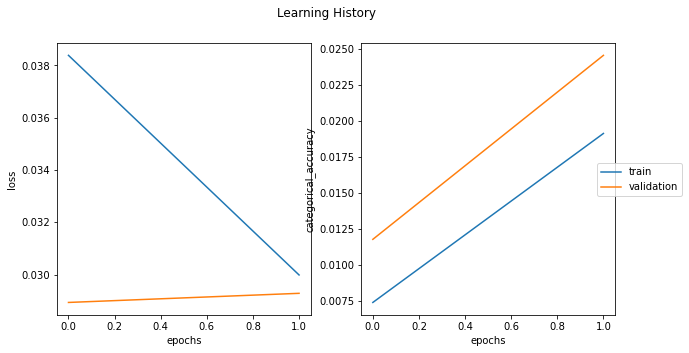


268/268 [==============================] - 123s 459ms/step
 precision:	0.02311
 recall:	0.43905
 f1_score:	0.04146


In [164]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_oversampled2.txt",
    data_list="../HARRISON/data_list_oversampled2.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

evaluate(model, 2)

### 3. Oversampling (from Notebook 2 & 3)

Found 79020 validated image filenames belonging to 997 classes.
Found 19756 validated image filenames belonging to 997 classes.

Epoch 1/50
2469/2469 [==============================] - 1751s 709ms/step - loss: 0.0758 - categorical_accuracy: 0.0016 - val_loss: 0.0646 - val_categorical_accuracy: 0.0048
Epoch 2/50
2469/2469 [==============================] - 1749s 709ms/step - loss: 0.0657 - categorical_accuracy: 0.0071 - val_loss: 0.0645 - val_categorical_accuracy: 0.0129
Epoch 3/50
2469/2469 [==============================] - 1823s 738ms/step - loss: 0.0614 - categorical_accuracy: 0.0175 - val_loss: 0.0521 - val_categorical_accuracy: 0.0242
Epoch 4/50
2469/2469 [==============================] - 1820s 737ms/step - loss: 0.0569 - categorical_accuracy: 0.0330 - val_loss: 0.0582 - val_categorical_accuracy: 0.0384

Model saved as ../model/1202032514_9-model3



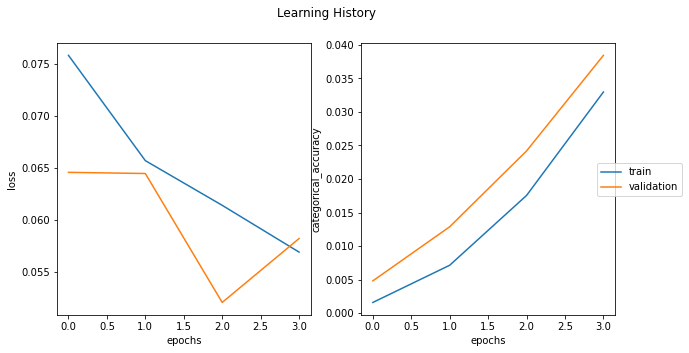

History saved as ../log/1202032514_9-history3

precision:	0.01155
recall:		0.26800
f1_score:	0.02122


In [9]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_oversampled23.txt",
    data_list="../HARRISON/data_list_oversampled23.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

evaluate(model, 3)

### 4. MLSOL Dataset (form Notebook 3 & 4)

Found 61758 validated image filenames belonging to 997 classes.
Found 15431 validated image filenames belonging to 997 classes.

Epoch 1/50
1929/1929 [==============================] - 1233s 639ms/step - loss: 0.0926 - categorical_accuracy: 0.0018 - val_loss: 0.0857 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
1929/1929 [==============================] - 1238s 642ms/step - loss: 0.0816 - categorical_accuracy: 0.0010 - val_loss: 0.0938 - val_categorical_accuracy: 8.4421e-04

Model saved as ../model/1202040834_9-model4



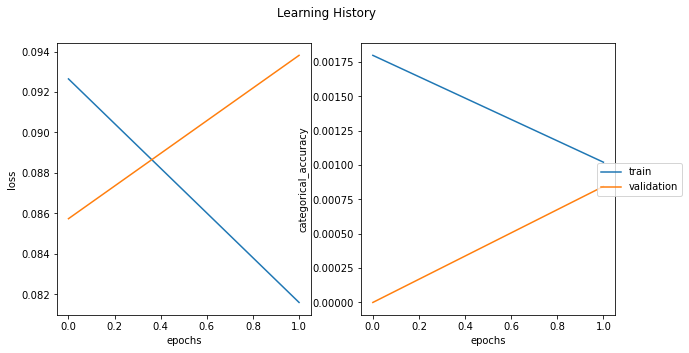

History saved as ../log/1202040834_9-history4

precision:	0.01154
recall:		0.36146
f1_score:	0.02205


In [10]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_aug.txt",
    data_list="../HARRISON/data_list_aug.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

evaluate(model, 4)

### 5. Google Images (from Notebook 6)

Found 167345 validated image filenames belonging to 997 classes.
Found 41837 validated image filenames belonging to 997 classes.

Epoch 1/50
5229/5229 [==============================] - 3279s 627ms/step - loss: 0.0171 - categorical_accuracy: 0.0107 - val_loss: 0.0158 - val_categorical_accuracy: 0.0154
Epoch 2/50
5229/5229 [==============================] - 3116s 596ms/step - loss: 0.0140 - categorical_accuracy: 0.0181 - val_loss: 0.0141 - val_categorical_accuracy: 0.0189
Epoch 3/50
5229/5229 [==============================] - 3118s 596ms/step - loss: 0.0139 - categorical_accuracy: 0.0197 - val_loss: 0.0152 - val_categorical_accuracy: 0.0214

Model saved as ../model/1202012407_9-model5



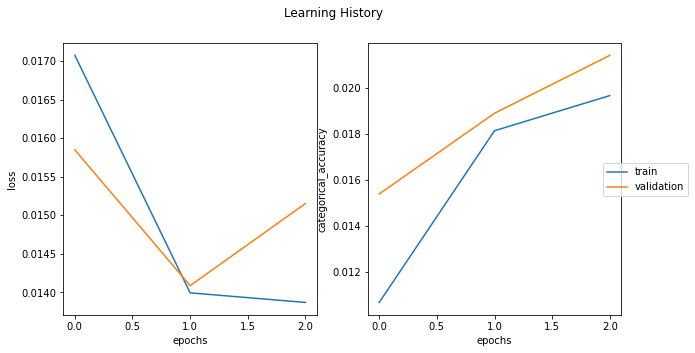

History saved as ../log/1202012407_9-history5

precision:	0.02466
recall:		0.50833
f1_score:	0.04593


In [8]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_mixed.txt",
    data_list="../HARRISON/data_list_mixed.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

evaluate(model, 5)

### 6. 100 Image/Lable (from Notebook 8)

In [162]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_100.txt",
    data_list="../HARRISON/data_list_100.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

# evaluate(model, 6)
model = load_model("../model/1201183327_9-model6")
step_size = test_generator.n // test_generator.batch_size
pred = model.predict(test_generator, steps=step_size)
y_pred = [hashtags[idx] for idx in pred>pred.mean()+pred.std()]
show_report(y_true, y_pred)

 precision:	0.00486
 recall:	0.14368
 f1_score:	0.00930


### 7. Using Original Dataset + Model Definition 2

Found 39020 validated image filenames belonging to 997 classes.
Found 9756 validated image filenames belonging to 997 classes.

Epoch 1/50
1219/1219 [==============================] - 897s 736ms/step - loss: 0.0294 - categorical_accuracy: 0.0212 - val_loss: 0.0257 - val_categorical_accuracy: 0.0231
Epoch 2/50
1219/1219 [==============================] - 905s 743ms/step - loss: 0.0254 - categorical_accuracy: 0.0308 - val_loss: 0.0284 - val_categorical_accuracy: 0.0315

Model saved as ../model/1202122203_9-model7



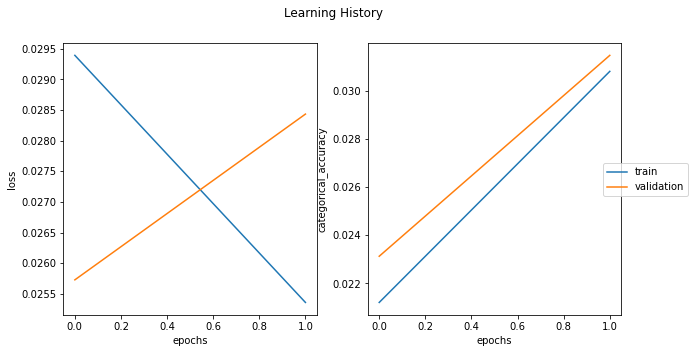

History saved as ../log/1202122204_9-history7

precision:	0.02684
recall:		0.47758
f1_score:	0.04947


In [5]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_train.txt",
    data_list="../HARRISON/data_list_train.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtags.txt")

evaluate(model, 7, 2)

### 8. Using Original Image + Top  300 Hashtags

Found 38857 validated image filenames belonging to 300 classes.
Found 9716 validated image filenames belonging to 300 classes.

Epoch 1/50
1214/1214 [==============================] - 1012s 834ms/step - loss: 0.0757 - categorical_accuracy: 0.0169 - val_loss: 0.0603 - val_categorical_accuracy: 0.0273
Epoch 2/50
1214/1214 [==============================] - 978s 806ms/step - loss: 0.0591 - categorical_accuracy: 0.0308 - val_loss: 0.0520 - val_categorical_accuracy: 0.0370
Epoch 3/50
1214/1214 [==============================] - 1000s 823ms/step - loss: 0.0580 - categorical_accuracy: 0.0344 - val_loss: 0.0645 - val_categorical_accuracy: 0.0343

Model saved as ../model/1202140227_9-model8



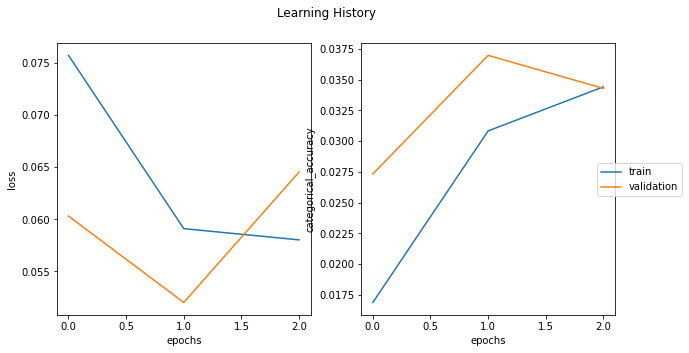

History saved as ../log/1202140228_9-history8

precision:	0.03465
recall:		0.39618
f1_score:	0.06111


In [6]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_train.txt",
    data_list="../HARRISON/data_list_train.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtag300.txt")

evaluate(model, 8)

### 9. Using Original Image + Top  200 Hashtags

Found 38802 validated image filenames belonging to 200 classes.
Found 9697 validated image filenames belonging to 200 classes.

Epoch 1/50
1212/1212 [==============================] - 921s 760ms/step - loss: 0.0902 - categorical_accuracy: 0.0200 - val_loss: 0.0750 - val_categorical_accuracy: 0.0299
Epoch 2/50
1212/1212 [==============================] - 1005s 829ms/step - loss: 0.0754 - categorical_accuracy: 0.0346 - val_loss: 0.0720 - val_categorical_accuracy: 0.0354
Epoch 3/50
1212/1212 [==============================] - 930s 767ms/step - loss: 0.0739 - categorical_accuracy: 0.0408 - val_loss: 0.0804 - val_categorical_accuracy: 0.0426

Model saved as ../model/1202145353_9-model8



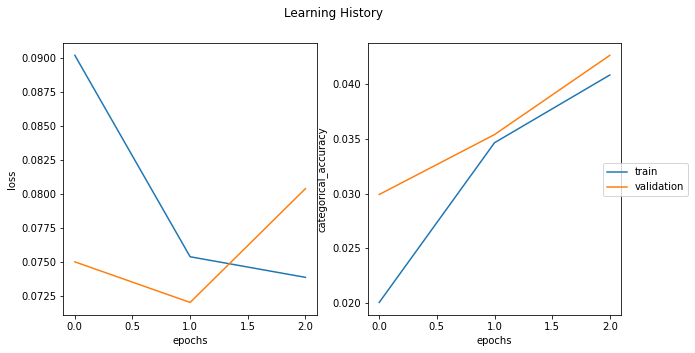

History saved as ../log/1202145354_9-history8

precision:	0.03780
recall:		0.31126
f1_score:	0.06376


In [8]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_train.txt",
    data_list="../HARRISON/data_list_train.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtag200.txt")

evaluate(model, 9)

### 10. Using Original Image + Top  100 Hashtags

Found 38625 validated image filenames belonging to 100 classes.
Found 9659 validated image filenames belonging to 100 classes.

Epoch 1/50
1207/1207 [==============================] - 900s 745ms/step - loss: 0.1247 - categorical_accuracy: 0.0265 - val_loss: 0.1095 - val_categorical_accuracy: 0.0370
Epoch 2/50
1207/1207 [==============================] - 902s 747ms/step - loss: 0.1113 - categorical_accuracy: 0.0429 - val_loss: 0.1041 - val_categorical_accuracy: 0.0547
Epoch 3/50
1207/1207 [==============================] - 894s 741ms/step - loss: 0.1091 - categorical_accuracy: 0.0502 - val_loss: 0.1190 - val_categorical_accuracy: 0.0501

Model saved as ../model/1203003606_9-model10



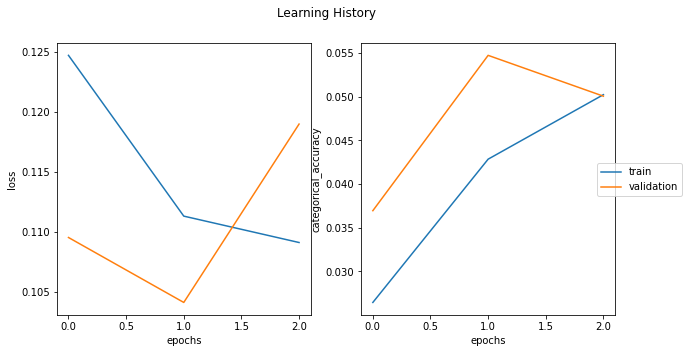

History saved as ../log/1203003607_9-history10

precision:	0.04850
recall:		0.19289
f1_score:	0.06939


In [6]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_train.txt",
    data_list="../HARRISON/data_list_train.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtag100.txt")

evaluate(model, 10)

### 11. Using Google Image + Top  300 Hashtags

Found 131947 validated image filenames belonging to 300 classes.
Found 32957 validated image filenames belonging to 300 classes.

Epoch 1/50
4123/4123 [==============================] - 2564s 622ms/step - loss: 0.0449 - categorical_accuracy: 0.0207 - val_loss: 0.0412 - val_categorical_accuracy: 0.0338
Epoch 2/50
4123/4123 [==============================] - 2533s 614ms/step - loss: 0.0395 - categorical_accuracy: 0.0352 - val_loss: 0.0452 - val_categorical_accuracy: 0.0370

Model saved as ../model/1202162256_9-model10



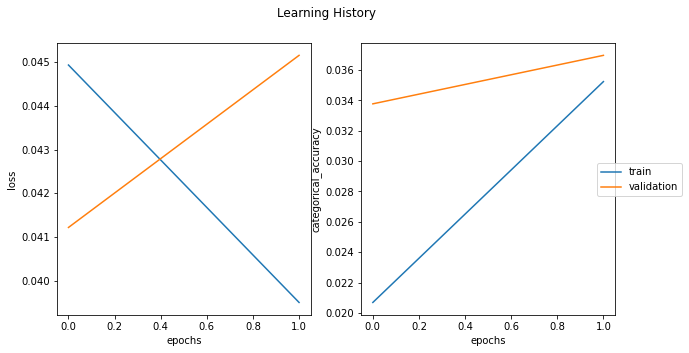

History saved as ../log/1202162257_9-history10

precision:	0.02915
recall:		0.39675
f1_score:	0.05219


In [6]:
model = SingleOutput(
    tag_list="../HARRISON/tag_list_mixed.txt",
    data_list="../HARRISON/data_list_mixed.txt",
    image_dir="../HARRISON/images",
    hashtag="../HARRISON/hashtag300_g.txt")

evaluate(model, 11)